In [1]:
# Step 1: Import Libraries
# ============================
import pandas as pd 
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing import image_dataset_from_directory
import matplotlib.pyplot as plt
from tensorflow.keras import layers, models
from sklearn.metrics import classification_report, accuracy_score , ConfusionMatrixDisplay , confusion_matrix



In [2]:

# Step 2: Define Paths & Params
# ============================
data_dir = "D:/BE Project/AI-dvriven-Driver-behaviour-Monitoring-System/Data/driver_dataset"   
img_height, img_width = 224, 224
batch_size = 32


In [3]:
# Step 3: Load Dataset
# ============================
train_ds = image_dataset_from_directory(
    data_dir,
    validation_split=0.2,   # 80/20 split
    subset="training",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size
)


Found 2000 files belonging to 4 classes.
Using 1600 files for training.


In [4]:
val_ds = image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

Found 2000 files belonging to 4 classes.
Using 400 files for validation.


In [5]:
# Step 4: Inspect Classes
# ============================
class_names = train_ds.class_names
print("Class Names:", class_names)

Class Names: ['closed_eyes', 'not_yawn', 'open_eyes', 'yawn']


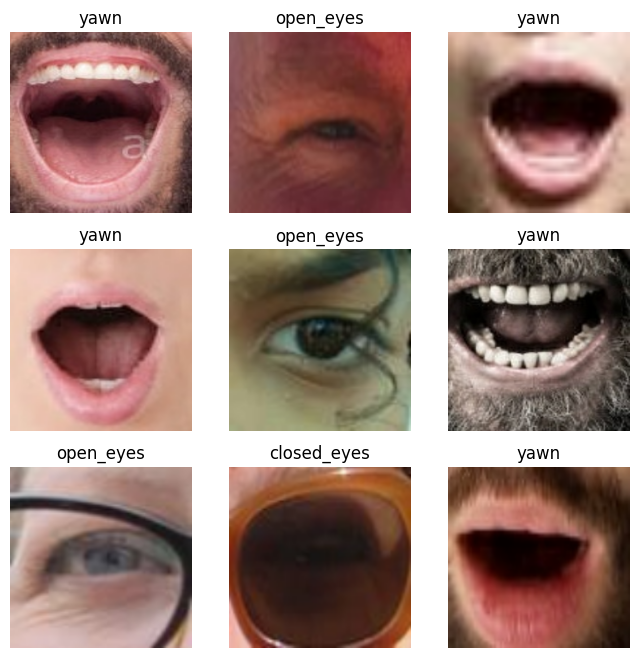

In [6]:
# Step 5: Visualize Sample Images
# ============================
plt.figure(figsize=(8, 8))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

In [7]:
# Step 6: Normalize Data
# ============================
normalization_layer = tf.keras.layers.Rescaling(1./255)

train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
val_ds = val_ds.map(lambda x, y: (normalization_layer(x), y))
print("Data normalization complete.")

Data normalization complete.


In [8]:
# Step 7: Data Augmentation
# ============================
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.1),
    tf.keras.layers.RandomZoom(0.1),
])

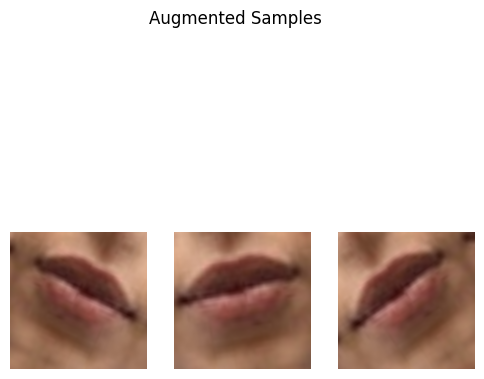

In [9]:
# Example: show augmented image
for images, labels in train_ds.take(1):
    plt.figure(figsize=(6, 6))
    for i in range(3):
        augmented_img = data_augmentation(images)[0]
        plt.subplot(1, 3, i+1)
        plt.imshow(augmented_img.numpy())
        plt.axis("off")
    plt.suptitle("Augmented Samples")
    plt.show()

In [10]:
# Step 8: Optimize Performance
# ============================
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

print("\n✅ Image data preprocessing completed. Ready for model training!")


✅ Image data preprocessing completed. Ready for model training!


CNN Model

In [ ]:
# train_ds, val_ds, class_names, data_augmentation are already defined
num_classes = len(class_names)

In [12]:
# Step 3: Build Custom CNN
# ============================
cnn_model = models.Sequential([
    data_augmentation,
    layers.Conv2D(32, (3,3), activation='relu', input_shape=(224,224,3)),
    layers.MaxPooling2D(),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(128, (3,3), activation='relu'),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(num_classes, activation='softmax')
])

c:\Program Files\Python313\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [13]:
cnn_model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

print("\n✅ Custom CNN Summary:")
cnn_model.summary()



✅ Custom CNN Summary:


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ (32, 224, 224, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (32, 222, 222, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (32, 111, 111, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (32, 109, 109, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (32, 54, 54, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (32, 52, 52, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (32, 26, 26, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (32, 86528)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (32, 128)              │    11,075,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (32, 128)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (32, 4)                │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,169,476 (42.61 MB)

 Trainable params: 11,169,476 (42.61 MB)

 Non-trainable params: 0 (0.00 B)

In [14]:
# Step 4: Train Custom CNN
# ============================
history_cnn = cnn_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10
)

Epoch 1/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 52s 937ms/step - accuracy: 0.4425 - loss: 1.2983 - val_accuracy: 0.6775 - val_loss: 0.7768
Epoch 2/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 51s 1s/step - accuracy: 0.7556 - loss: 0.6714 - val_accuracy: 0.8625 - val_loss: 0.4220
Epoch 3/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 55s 1s/step - accuracy: 0.8294 - loss: 0.4893 - val_accuracy: 0.8650 - val_loss: 0.4224
Epoch 4/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 77s 1s/step - accuracy: 0.8369 - loss: 0.4518 - val_accuracy: 0.8775 - val_loss: 0.3128
Epoch 5/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 56s 1s/step - accuracy: 0.8438 - loss: 0.4098 - val_accuracy: 0.9025 - val_loss: 0.2770
Epoch 6/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 58s 1s/step - accuracy: 0.8569 - loss: 0.3798 - val_accuracy: 0.9225 - val_loss: 0.2168
Epoch 7/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 52s 1s/step - accuracy: 0.8844 - loss: 0.3318 - val_accuracy: 0.8975 - val_loss: 0.2358
Epoch 8/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 80s 1s/step - accuracy: 0.8869 - loss: 0.3004 - val_accuracy: 0.9200 - val_lo

In [15]:
# Step 5: Build MobileNetV2
# ============================
base_model = tf.keras.applications.MobileNetV2(
    input_shape=(224,224,3),
    include_top=False,
    weights="imagenet"
)
base_model.trainable = False

mobilenet_model = models.Sequential([
    data_augmentation,
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dropout(0.3),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(num_classes, activation='softmax')
])

mobilenet_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
                        loss='sparse_categorical_crossentropy',
                        metrics=['accuracy'])

print("\n✅ MobileNetV2 Summary:")
mobilenet_model.summary()


✅ MobileNetV2 Summary:


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ (32, 224, 224, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (32, 7, 7, 1280)       │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (32, 1280)             │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (32, 1280)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (32, 128)              │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (32, 128)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (32, 4)                │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,422,468 (9.24 MB)

 Trainable params: 164,484 (642.52 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [16]:
# Step 6: Train MobileNetV2
# ============================
history_mobilenet = mobilenet_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10
)

Epoch 1/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 48s 882ms/step - accuracy: 0.4137 - loss: 1.3672 - val_accuracy: 0.7225 - val_loss: 0.7828
Epoch 2/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 50s 995ms/step - accuracy: 0.6475 - loss: 0.8597 - val_accuracy: 0.8625 - val_loss: 0.5168
Epoch 3/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 44s 883ms/step - accuracy: 0.7556 - loss: 0.6232 - val_accuracy: 0.8850 - val_loss: 0.3955
Epoch 4/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 43s 872ms/step - accuracy: 0.7987 - loss: 0.5410 - val_accuracy: 0.8825 - val_loss: 0.3517
Epoch 5/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 46s 917ms/step - accuracy: 0.8369 - loss: 0.4428 - val_accuracy: 0.9150 - val_loss: 0.2942
Epoch 6/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 44s 875ms/step - accuracy: 0.8356 - loss: 0.4460 - val_accuracy: 0.9125 - val_loss: 0.2983
Epoch 7/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 47s 950ms/step - accuracy: 0.8675 - loss: 0.3824 - val_accuracy: 0.9325 - val_loss: 0.2503
Epoch 8/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 45s 902ms/step - accuracy: 0.8731 - loss: 0.3664 - val_accu

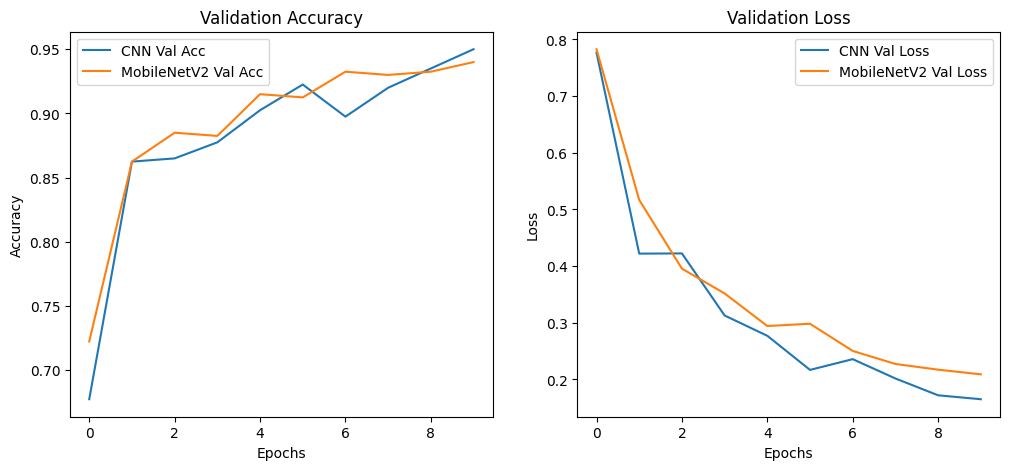

In [17]:
# Step 7: Compare Training Curves
# ============================
plt.figure(figsize=(12,5))

# Accuracy
plt.subplot(1,2,1)
plt.plot(history_cnn.history['val_accuracy'], label="CNN Val Acc")
plt.plot(history_mobilenet.history['val_accuracy'], label="MobileNetV2 Val Acc")
plt.title("Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()

# Loss
plt.subplot(1,2,2)
plt.plot(history_cnn.history['val_loss'], label="CNN Val Loss")
plt.plot(history_mobilenet.history['val_loss'], label="MobileNetV2 Val Loss")
plt.title("Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

plt.show()


In [18]:
# Step 8: Confusion Matrix + Report
# ============================
def evaluate_model(model, val_ds, model_name):
    y_true, y_pred = [], []
    for images, labels in val_ds:
        preds = model.predict(images)
        y_true.extend(labels.numpy())
        y_pred.extend(np.argmax(preds, axis=1))

    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    disp.plot(cmap="Blues", xticks_rotation=45)
    plt.title(f"Confusion Matrix - {model_name}")
    plt.show()

    print(f"\nClassification Report - {model_name}")
    print(classification_report(y_true, y_pred, target_names=class_names))

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 472ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 263ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 263ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 306ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 313ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 260ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 254ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 255ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 274ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 262ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 257ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 331ms/step


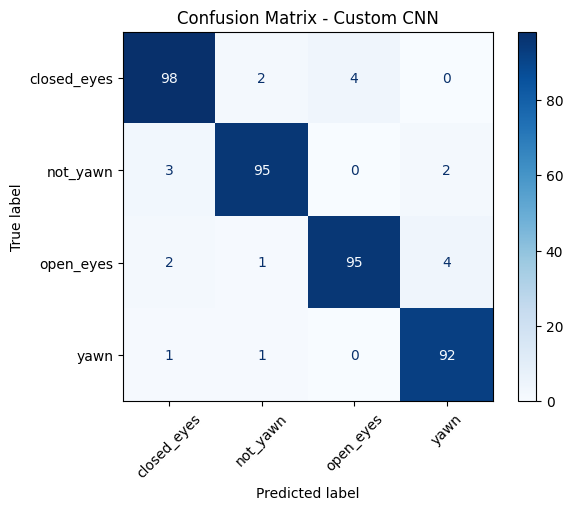


Classification Report - Custom CNN
              precision    recall  f1-score   support

 closed_eyes       0.94      0.94      0.94       104
    not_yawn       0.96      0.95      0.95       100
   open_eyes       0.96      0.93      0.95       102
        yawn       0.94      0.98      0.96        94

    accuracy                           0.95       400
   macro avg       0.95      0.95      0.95       400
weighted avg       0.95      0.95      0.95       400



In [19]:
# Evaluate CNN
evaluate_model(cnn_model, val_ds, "Custom CNN")

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 681ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 696ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 634ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 685ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 644ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 600ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 613ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 618ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 593ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 621ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 616ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


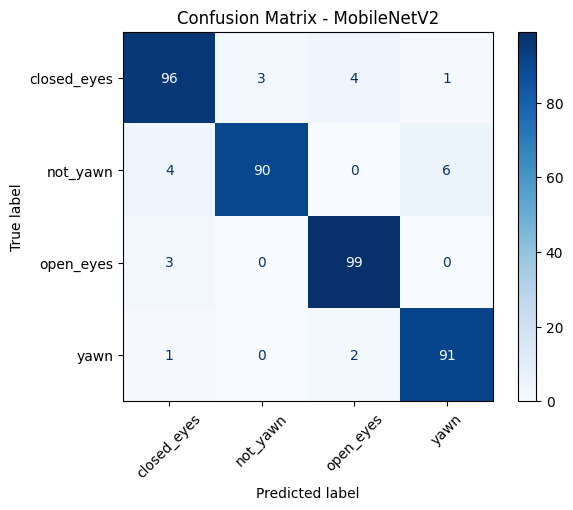


Classification Report - MobileNetV2
              precision    recall  f1-score   support

 closed_eyes       0.92      0.92      0.92       104
    not_yawn       0.97      0.90      0.93       100
   open_eyes       0.94      0.97      0.96       102
        yawn       0.93      0.97      0.95        94

    accuracy                           0.94       400
   macro avg       0.94      0.94      0.94       400
weighted avg       0.94      0.94      0.94       400



In [20]:
# Evaluate MobileNetV2
evaluate_model(mobilenet_model, val_ds, "MobileNetV2")

In [21]:
# Step 9: Save Best Model
# ============================
# Example: save MobileNetV2 (if it performs better)
mobilenet_model.save("driver_cnn_mobilenetv2.h5")
cnn_model.save("driver_custom_cnn.h5")

print("\n✅ Both models saved. Pick the one with higher accuracy.")


✅ Both models saved. Pick the one with higher accuracy.
